In [1]:
%load_ext autoreload
%autoreload 2
import litebird_sim as lbs
import numpy as np
import healpy as hp
import sbm
import logging
import toml
from pathlib import Path
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.WARNING);

In [2]:
CONFIG_PATH = Path.home() / ".config" / "litebird_imo"
CONFIG_FILE_PATH = CONFIG_PATH / "imo.toml"
tomlinfo = toml.load(CONFIG_FILE_PATH)
flatfile_location = tomlinfo["repositories"][0]["location"]

imo = lbs.Imo(flatfile_location=flatfile_location)

In [3]:
channel = sbm.channel_list[0]

config = sbm.Configlation(imo, channel)
config.mdim = 2
config.spin_n_basis = [0, 2, -2]
config.spin_m_basis = [0, 0, 0]
config.parallel = True
config.nside = 128
config.xlink_threshold = 0.7
config.use_hwp = False

syst = sbm.Systematics()
syst.sigma_gain_T = 0.1
syst.sigma_gain_B = 0.1

syst.sigma_rho_T = np.deg2rad(1 / 60)
syst.sigma_rho_B = 0.0

syst.sigma_chi_T = 0.0
syst.sigma_chi_B = 0.0

Here, we will take a `N` realisations for CMB, systematics variations and noise.


In [4]:
N = 2
start_seed = 0
end_seed = start_seed + N
cmb_syst_seed_array = np.arange(start_seed, end_seed)
fg_models = ["pysm_dust_1", "pysm_synch_1"]

npix = hp.nside2npix(config.nside)
gain_maps = np.zeros([N, N, 3, npix])
pointing_maps = np.zeros([N, N, 3, npix])
noise_maps = np.zeros([N, 3, npix])

lmax = 3 * config.nside - 1
delta_cl_gain = np.zeros([N, N, 6, lmax + 1])
delta_cl_pointing = np.zeros([N, N, 6, lmax + 1])
cl_noise = np.zeros([N, 6, lmax + 1])

for i, cmb_seed in enumerate(cmb_syst_seed_array):
    Mbsparams = lbs.MbsParameters(
        make_cmb=True,
        cmb_r=0.001,
        make_fg=True,
        seed_cmb=cmb_seed,
        fg_models=fg_models,
        gaussian_smooth=False,
        bandpass_int=False,
        nside=config.nside,
        units="uK_CMB",
        maps_in_ecliptic=False,
    )
    syst.noise_seed = cmb_seed
    for j, syst_seed in enumerate(cmb_syst_seed_array):
        syst.syst_seed = syst_seed
        print(
            f"CMB seed: {cmb_seed} | Noise seed {syst.noise_seed} | Syst. seed: {syst.syst_seed}"
        )
        gain_map, input_maps = sbm.sim_diff_gain_per_ch(config, syst, Mbsparams)
        pointing_map, input_maps = sbm.sim_diff_pointing_per_ch(config, syst, Mbsparams)
        noise_map = sbm.sim_noise_per_ch(config, syst)
        gain_maps[i, j] = gain_map
        pointing_maps[i, j] = pointing_map

        input_map = (
            input_maps["cmb"]
            + input_maps["fg"][fg_models[0]]
            + input_maps["fg"][fg_models[1]]
        )[0]
        delta_cl_gain[i, j] = hp.anafast(gain_map - input_map)
        delta_cl_pointing[i, j] = hp.anafast(pointing_map - input_map)
        if j == 0:
            noise_maps[i] = noise_map
            cl_noise[i] = hp.anafast(noise_map)

CMB seed: 0 | Noise seed 0 | Syst. seed: 0


Processing L1-040: 100%|██████████| 24/24 [00:03<00:00,  7.36it/s]


CMB seed: 0 | Noise seed 0 | Syst. seed: 1


Processing L1-040: 100%|██████████| 24/24 [00:03<00:00,  6.75it/s]


CMB seed: 1 | Noise seed 1 | Syst. seed: 0


Processing L1-040: 100%|██████████| 24/24 [00:04<00:00,  5.31it/s]


CMB seed: 1 | Noise seed 1 | Syst. seed: 1


Processing L1-040: 100%|██████████| 24/24 [00:03<00:00,  6.73it/s]


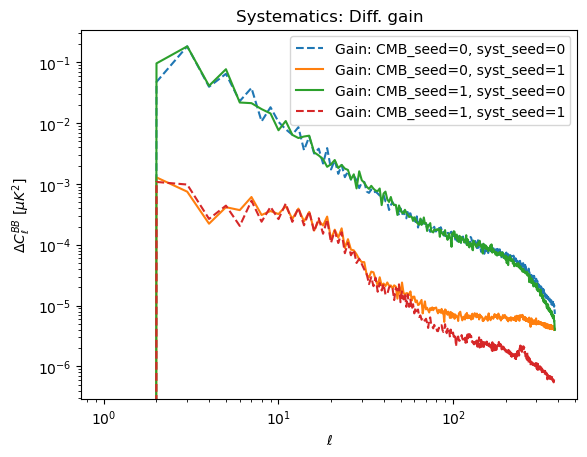

In [5]:
for i, cmb_seed in enumerate(cmb_syst_seed_array):
    for j, syst_seed in enumerate(cmb_syst_seed_array):
        if i != j:
            line = "-"
        else:
            line = "--"
        plt.loglog(
            delta_cl_gain[i, j, 2, :],
            line,
            label=f"Gain: CMB_seed={cmb_seed}, syst_seed={syst_seed}",
        )
plt.title("Systematics: Diff. gain")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell^{BB}$ [$\mu K^2$]")
plt.legend()

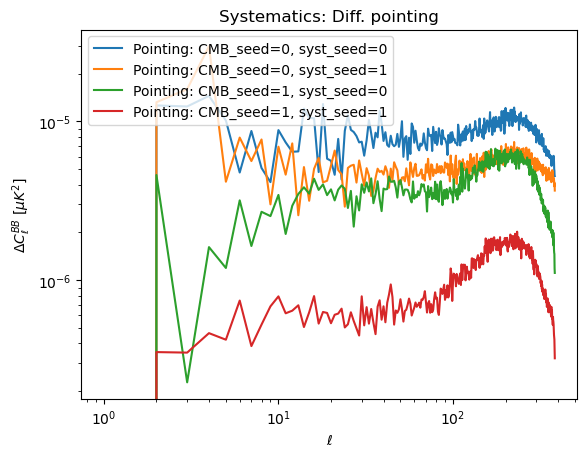

In [6]:
for i in range(N):
    for j in range(N):
        plt.loglog(
            delta_cl_pointing[i, j, 2, :],
            label=f"Pointing: CMB_seed={i}, syst_seed={j}",
        )
plt.title("Systematics: Diff. pointing")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Delta C_\ell^{BB}$ [$\mu K^2$]")
plt.legend()

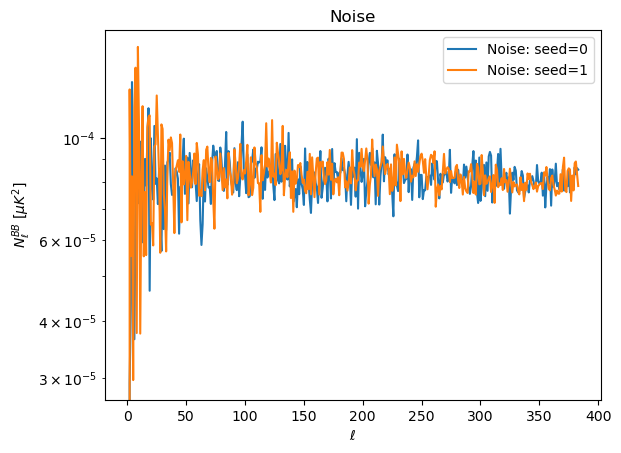

In [7]:
for i in range(N):
    plt.plot(cl_noise[i, 2, :], "-", label=f"Noise: seed={i}")
plt.title("Noise")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$N_\ell^{BB}$ [$\mu K^2$]")
plt.yscale("log")
plt.legend()